## Installs


In [1]:
! git clone https://github.com/Acciorocketships/sae.git

fatal: destination path 'sae' already exists and is not an empty directory.


In [29]:
!pip uninstall sae


Found existing installation: sae 1.1.0
Uninstalling sae-1.1.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/sae.egg-link
Proceed (Y/n)? y
  Successfully uninstalled sae-1.1.0


In [1]:
! pip install -e sae


Obtaining file:///home/rand/github/XMED521/proj/sae
  Preparing metadata (setup.py) ... - done
  Using cached torch-2.5.1-cp310-cp310-manylinux1_x86_64.whl.metadata (28 kB)
Using cached torch-2.5.1-cp310-cp310-manylinux1_x86_64.whl (906.4 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0
    Uninstalling torch-2.3.0:
      Successfully uninstalled torch-2.3.0
  Attempting uninstall: sae
    Found existing installation: sae 1.1.0
    Uninstalling sae-1.1.0:
      Successfully uninstalled sae-1.1.0
  DEPRECATION: Legacy editable install of sae==1.1.0 from file:///home/rand/github/XMED521/proj/sae (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion ca

In [1]:

import torch
from torch import nn, optim
from sae import AutoEncoder
import scanpy as sc
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Dataset

In [4]:
import scanpy as sc

def split_data(X, subject_ids, unique_ids):
  unique_ids = subject_ids.unique()
  data = [[] for _ in range(X.shape[1])]
  sizes = [[] for _ in range(X.shape[1])]
  for i in range(X.shape[1]):
    for j, subject_id in enumerate(unique_ids):
      subject_indices = subject_ids == subject_id
      subject_data = X[subject_indices, i]
      data[i].append(torch.from_numpy(subject_data.toarray()))
      sizes[i].append(torch.tensor([subject_data.shape[0]],dtype = torch.int32))
  return data, sizes

def collate(batch):
      """
      x = torch.cat(data[0], dim=0)
      sizes = torch.cat(sizes[0], dim=0)
      batch = torch.arange(sizes.numel()).repeat_interleave(sizes)
      """
      data = [item[0] for item in batch]
      sizes = [item[1] for item in batch]
      target = [item[2] for item in batch]
      gene = [item[3] for item in batch]
      subject = [item[4] for item in batch]
      x = torch.cat(data, dim=0)
      sizes = torch.cat([item[1] for item in batch], dim=0)
      batch = torch.arange(sizes.numel()).repeat_interleave(sizes)
      target = torch.LongTensor(target)
      gene = torch.LongTensor(gene)
      subject = torch.LongTensor(subject)
      return x, batch, target, gene, subject

class SCDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        adata,
        d_output=2, # default binary classification
        dest_path="/content", # default for colab
        return_augs=False,
    ):

        self.return_augs = return_augs
        self.d_output = d_output  # needed for decoder to grab
        self.adata = adata
        self.X  = self.adata.X

        self.num_genes = self.X.shape[1]

        self.subject_ids = self.adata.obs["subject_id"]
        self.unique_ids = self.subject_ids.unique()
        self.num_subjects = len(self.unique_ids)

        self.data, self.sizes = split_data(self.X, self.subject_ids, self.unique_ids)

        self.phenotypes = pd.read_csv('phenotypes.csv')
        self.labels = [self.phenotypes[self.phenotypes['Sample_ID']==int(unique_id)]['binary_y'] for unique_id in self.unique_ids]

    def __len__(self):
        return self.num_genes*self.num_subjects

    def __getitem__(self, idx):
        gene = idx // self.num_subjects
        subject = idx % self.num_subjects
        x = self.data[gene][subject]
        size = self.sizes[gene][subject]
        target = self.labels[subject].item()
        return x, size, target, gene, subject

### Junk

In [ ]:
adata = sc.read("/content/processed_dataset.h5ad")

In [ ]:
adata.X.shape

(5296, 128)

In [ ]:
subject_ids = adata.obs['subject_id']

In [ ]:
def split_data(X, subject_ids):
  unique_ids = subject_ids.unique()
  data = [[] for _ in range(X.shape[1])]
  sizes = [[] for _ in range(X.shape[1])]
  for i in range(X.shape[1]):
    for j, subject_id in enumerate(unique_ids):
      subject_indices = subject_ids == subject_id
      subject_data = X[subject_indices, i]
      data[i].append(torch.from_numpy(subject_data.toarray()))
      sizes[i].append(torch.tensor([subject_data.shape[0]],dtype = torch.int32))
  return data, sizes



In [ ]:
data, sizes = split_data(adata.X, subject_ids)

In [ ]:
len(data[0])

14

In [ ]:
import random
class MyDataLoader:
    def __init__(self, dataset, batch_size, shuffle = True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = list(range(len(dataset)))

    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.indices)
        self.current_index = 0
        return self

    def __next__(self):
        if self.current_index >= len(self.dataset):
            raise StopIteration
        btach_indices = self.indices[self.current_index:self.current_index + self.batch_size]
        batch = [self.dataset[i] for i in batch_indices]
        self.current_index += self.batch_size
        return batch


## Autoencoder Training

In [5]:
def train_autoencoder(model, device, train_loader, optimizer, epoch, log_interval=5000):
    """Training loop."""
    model.train()
    for batch_idx, (data, size, target,_,_) in enumerate(train_loader):
        data, size = data.to(device), size.to(device)
        optimizer.zero_grad()
        xr, batchr = model(data, size)
        loss_data = model.loss()
        loss = loss_data["loss"]
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader),
                100. * batch_idx / len(train_loader), loss.item()))


In [6]:
def test_autoencoder(model, device, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, size, _ ,_,_ in test_loader:
            data, size = data.to(device), size.to(device)
            xr, batchr = model(data, size)
            loss_data = model.loss()
            loss = loss_data["loss"]
            test_loss += loss  # sum up batch loss

    test_loss /= len(test_loader.dataset)

    print(f"Test Loss: {test_loss}")
    #changed
    return test_loss

In [52]:
def run_train_autoencoder(test_subjects=None):

    # experiment settings:
    num_epochs = 220  # ~100 seems fine
    batch_size = 8
    learning_rate = .005  # good default for Hyena
    weight_decay = 0.1

    max_n = 700
    hidden_dim = 4
    dim = 1

    model = AutoEncoder(dim=dim, hidden_dim=hidden_dim, max_n=max_n)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Using device:", device)
    model.to(device)

    adata = sc.read("./processed_dataset.h5ad")
    subject_ids = adata.obs['subject_id']
    if test_subjects:
      train_adata = adata[~adata.obs['subject_id'].isin(test_subjects), :]
      test_adata = adata[adata.obs['subject_id'].isin(test_subjects), :]
    else:
      train_adata = adata
      test_adata = None


    # create datasets
    ds_train = SCDataset(
        adata=train_adata,
        d_output=2,
        dest_path="/content",
        return_augs=False,
    )
    train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, collate_fn = collate)
    if test_adata:
      ds_test = SCDataset(
          adata=test_adata,
          d_output=2,
          dest_path="/content",
          return_augs=False,
      )
      test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, collate_fn = collate)




    # create optimizer
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.to(device)
    accuracies = []
    best = 1000000
    best_state_dict = None
    patience = 5
    epoch_since_update = 0
    for epoch in range(num_epochs):
        train_autoencoder(model, device, train_loader, optimizer, epoch)
        if test_adata:
          accuracy = test_autoencoder(model, device, test_loader)
          accuracies.append(accuracy)
          if best - accuracy >0:
            best = accuracy
            best_state_dict = model.state_dict()
            epoch_since_update = 0
          else:
            epoch_since_update +=1
            if epoch_since_update >= patience:
              model.load_state_dict(best_state_dict)
              break

        optimizer.step()

    return model, accuracies, ds_train, ds_test

In [53]:
model, accuracies, ds_train, ds_test = run_train_autoencoder(test_subjects = ['20','19'])

Using device: cuda


/home/rand/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/rand/.local/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/rand/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/rand/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/rand/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/rand/github/XMED521/proj/sae/sae/sae_model.py:52: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel

Train Epoch: 0 [0/192 (0%)]	Loss: 122301.242188


/home/rand/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rand/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Test Loss: 23116.044921875
Train Epoch: 1 [0/192 (0%)]	Loss: 157948.500000
Test Loss: 21873.728515625
Train Epoch: 2 [0/192 (0%)]	Loss: 219556.515625
Test Loss: 20215.931640625
Train Epoch: 3 [0/192 (0%)]	Loss: 171829.609375
Test Loss: 18508.9296875
Train Epoch: 4 [0/192 (0%)]	Loss: 137945.656250
Test Loss: 16881.150390625
Train Epoch: 5 [0/192 (0%)]	Loss: 124544.093750
Test Loss: 15465.4111328125
Train Epoch: 6 [0/192 (0%)]	Loss: 139375.000000
Test Loss: 14247.28125
Train Epoch: 7 [0/192 (0%)]	Loss: 102057.593750
Test Loss: 13238.712890625
Train Epoch: 8 [0/192 (0%)]	Loss: 85176.281250
Test Loss: 12391.1318359375
Train Epoch: 9 [0/192 (0%)]	Loss: 99474.984375
Test Loss: 11706.779296875
Train Epoch: 10 [0/192 (0%)]	Loss: 63236.800781
Test Loss: 11156.40234375
Train Epoch: 11 [0/192 (0%)]	Loss: 110209.109375
Test Loss: 10706.3134765625
Train Epoch: 12 [0/192 (0%)]	Loss: 86262.484375
Test Loss: 10341.103515625
Train Epoch: 13 [0/192 (0%)]	Loss: 94833.664062
Test Loss: 10042.228515625
Tra

In [55]:
accuracies = [accuracy.cpu().numpy() for accuracy in accuracies]

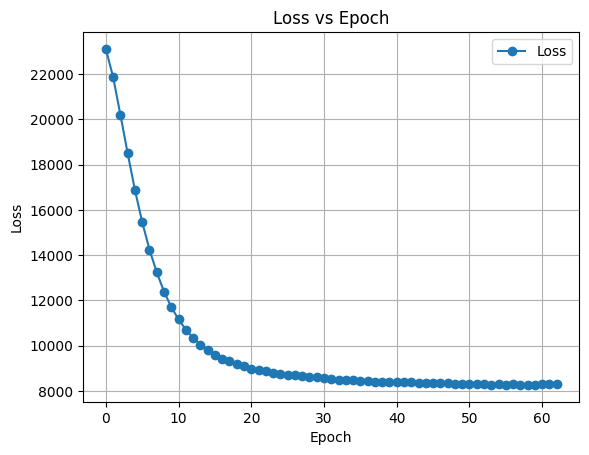

In [56]:
# COMPLETE THE PLOT FUNCTION HERE
plt.plot(range(len(accuracies)), accuracies, label= 'Loss',marker='o')


# Add axis labels
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add a title (optional)
plt.title('Loss vs Epoch')

# Add a legend (optional)
plt.legend()
# Show the graph
plt.grid()
plt.show()

## Encodings Dataset

In [57]:
def generate_embeddings(embedding_model, ds_train):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_loader = DataLoader(ds_train, batch_size=1, shuffle=False, collate_fn = collate)
    embeddings = []
    labels = []
    genes = []
    subjects = []
    with torch.no_grad():
        for data, size, y, gene, subject in train_loader:
            data, size = data.to(device), size.to(device)
            embedding = embedding_model(data, size)
            embeddings.append(embedding)
            labels.append(y)
            genes.append(gene.cpu().item())
            subjects.append(subject.cpu().item())
    return torch.stack(embeddings, axis=0).squeeze(), torch.stack(labels,axis=0), genes, subjects


In [58]:
embeddings, y , genes, subjects = generate_embeddings(model.encoder, ds_train)

In [59]:
def reshape_tensor_label(tensor, labels, gene_ids, subject_ids, num_genes, num_subjects):

    embedding_dim = tensor.shape[1]  # Get embedding dimension
    reshaped_tensor = torch.zeros((num_genes, num_subjects, embedding_dim))
    reshaped_labels = torch.zeros((num_genes, num_subjects))
    for i in range(tensor.shape[0]):
        gene_index = gene_ids[i]
        subject_index = subject_ids[i]
        reshaped_tensor[gene_index, subject_index] = tensor[i]
        reshaped_labels[gene_index, subject_index] = labels[i].item()
    return reshaped_tensor, reshaped_labels

In [60]:
reshaped_embeddings, reshaped_labels = reshape_tensor_label(embeddings, y, genes, subjects, ds_train.num_genes, ds_train.num_subjects)

## Prediction Models (they don't worj )

In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class LinearLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        scale = 1. * np.sqrt(6. / (input_dim + output_dim))
        # approximated posterior
        self.w = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-scale, scale))
        self.bias = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-scale, scale))

    def forward(self, x):
        output = torch.mm(x, self.w) + self.bias
        return output


class Predictor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Predictor, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)
        self.activation_fn = nn.Softplus(beta = 5)
        self.output_fn = nn.Sigmoid()

    def forward(self, x):
        x1 = self.activation_fn(self.hidden(x))
       # print(torch.sum(x1))
        x2 = self.output_fn(self.output(x1))
        #print(x2)
        #return x2, self.reg_layers()
        return x2

    def reg_layers(self):
        reg = torch.norm(self.Layer1.w, 1) + torch.norm(self.Layer2.w, 1)
        return reg



class Main_effect(nn.Module):
    def __init__(self, gene_size):
        super(Main_effect, self).__init__()
        self.input_dim = gene_size
        self.Layer1 = LinearLayer(self.input_dim, 1)

    def forward(self, x):
        x = self.Layer1(x)
        return x, self.reg_layers()

    def reg_layers(self):
        reg = torch.norm(self.Layer1.w, 1)
        return reg



class NNtraining(object):
    def __init__(self,
                 model,
                 learning_rate=0.05,
                 batch_size=10000,
                 num_epoch=10,
                 early_stop_patience = 20,
                 reg_weight_predictor = 0.0,
                 use_cuda=False,
                 use_early_stopping = False):

        self.model = model
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epoch = num_epoch
        self.best_val = 1e5
        self.early_stop_patience = early_stop_patience
        self.epochs_since_update = 0  # used for early stopping
        self.reg_weight_predictor = reg_weight_predictor
        self.use_early_stopping = use_early_stopping

        self.use_cuda = use_cuda
        if use_cuda:
            self.model.cuda()

    def training(self, x, y, xval, yval):

        parameters = set(self.model.parameters())
        optimizer = optim.Adam(parameters, lr=self.learning_rate, eps=1e-8)
        criterion = nn.BCELoss()
        if self.use_cuda:
            x = x.cuda()
            y = y.cuda()
        train_dl = DataLoader(TensorDataset(x, y), batch_size=self.batch_size, shuffle=True)
        for epoch in range(self.num_epoch):
            for x_batch, y_batch in train_dl:
                optimizer.zero_grad()
                self.model.train()
                # calculate the training loss
                #output, reg_predictor = self.model(x_batch)
                output = self.model(x_batch)
                #loss = criterion(y_batch, output) + self.reg_weight_predictor * reg_predictor
                print(output)
                print(y_batch.unsqueeze(1))
                loss = criterion(output,y_batch.unsqueeze(1))
                print(loss)
                # backpropogate the gradient
                loss.backward()
                # optimize with SGD
                optimizer.step()

            train_mse, train_pve = self.build_evaluation(x, y)
            val_mse, val_pve = self.build_evaluation(xval, yval)
            print('>>> Epoch {:5d}/{:5d} | train_mse={:.5f} | val_mse={:.5f} | train_pve={:.5f} | val_pve={:.5f}'.format(epoch,
                                                                                                                         self.num_epoch,
                                                                                                                         train_mse,
                                                                                                                         val_mse,
                                                                                                                         train_pve,
                                                                                                                         val_pve))
            if self.use_early_stopping:
                early_stop = self._early_stop(val_mse)
                if early_stop:
                    break


    def build_evaluation(self, x_test, y_test):
        criterion = nn.BCELoss()
        if self.use_cuda:
            x_test = x_test.cuda()
            y_test = y_test.cuda()
        self.model.eval()
        y_pred = self.model(x_test)
      #  y_pred, _, = self.model(x_test)
        mse_eval = criterion(y_test, y_pred).detach()

        pve = (1. - torch.var(y_pred.view(-1) - y_test.view(-1)) / torch.var(y_test.view(-1))).detach()
        return mse_eval, pve

    def _early_stop(self, val_loss):
        updated = False # flag
        current = val_loss
        best = self.best_val
        improvement = (best - current) / best
#         improvement  = best - current

        if improvement > 0.00:
            self.best_val = current
            updated = True

        if updated:
            self.epochs_since_update = 0
        else:
            self.epochs_since_update += 1

        return self.epochs_since_update > self.early_stop_patience


In [ ]:
predictor= Predictor(reshaped_embeddings.shape[0]*reshaped_embeddings.shape[2], 100)
gene_interaction_nn = NNtraining(predictor,batch_size =1,)
gene_interaction_nn.training(x,y, xval,yval)

##Prediction (something is wrong it only outputs zeros)

In [18]:
def transform_split(tensor, labels, split = .8):
  transformed = tensor.reshape(tensor.shape[1],tensor.shape[0]*tensor.shape[2])
  labels = labels[0,:]
  split1 = int(tensor.shape[1]*split)
  tensor1 = transformed[:split1,:]
  tensor2 = transformed[split1:,:]
  labels1 = labels[:split1]
  labels2 = labels[split1:]
  return tensor1, tensor2, labels1, labels2

In [66]:
x, xval,y,yval = transform_split(reshaped_embeddings, reshaped_labels)

In [69]:
from torch.utils.data import TensorDataset, DataLoader
class GeneInteractionNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GeneInteractionNN, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)
        self.activation_fn = nn.Softplus(beta = 5)


    def forward(self, x):
        x = self.activation_fn(self.hidden(x))
        x = torch.sigmoid(self.output(x))
        return x


In [70]:
def train_predictor(model, device, train_loader, optimizer, epoch,loss_fn):
    """Training loop."""
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()


In [84]:
def test_predictor(model, device, test_loader, loss_fn):
    model.eval()
    with torch.no_grad():
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            print(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (100.* correct / len(test_loader.dataset)), test_loss

In [74]:
def run_train_predictor(x, y, xval, yval):
    learning_rate = 0.001
    epochs = 100

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    input_dim = x.shape[1]
    hidden_dim = 32

    model = GeneInteractionNN(input_dim, hidden_dim)

    train_dl = DataLoader(TensorDataset(x, y.unsqueeze(1)), batch_size=1, shuffle=True)
    test_dl = DataLoader(TensorDataset(xval, yval.unsqueeze(1)), batch_size=1, shuffle=False)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)
    accuracies = []
    losses = []
    for epoch in range(epochs):
        train_predictor(model, device, train_dl, optimizer, epoch, loss_fn)
        accuracy, loss = test_predictor(model, device, test_dl, loss_fn)
        accuracies.append(accuracy)
        losses.append(loss)
        optimizer.step()
    return model, accuracies, losses



In [85]:
model, accuracies, losses = run_train_predictor(x,y,xval,yval)

tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')

Test set: Average loss: 0.7079, Accuracy: 2/3 (66.67%)

tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')

Test set: Average loss: 0.7083, Accuracy: 2/3 (66.67%)

tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')

Test set: Average loss: 0.7069, Accuracy: 2/3 (66.67%)

tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')

Test set: Average loss: 0.7056, Accuracy: 2/3 (66.67%)

tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')

Test set: Average loss: 0.7026, Accuracy: 2/3 (66.67%)

tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')

Test set: Average loss: 0.7019, Accuracy: 2/3 (66.67%)

tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')

Test s

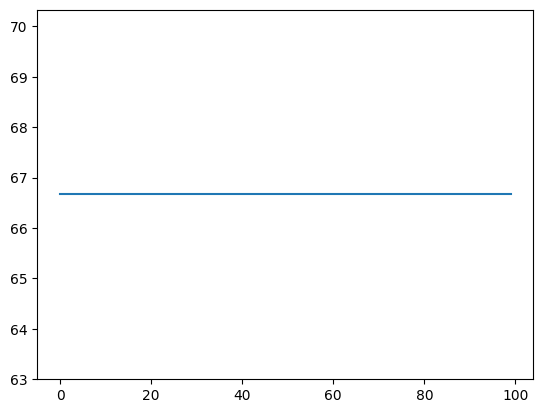

In [77]:
plt.plot(range(len(accuracies)),accuracies)

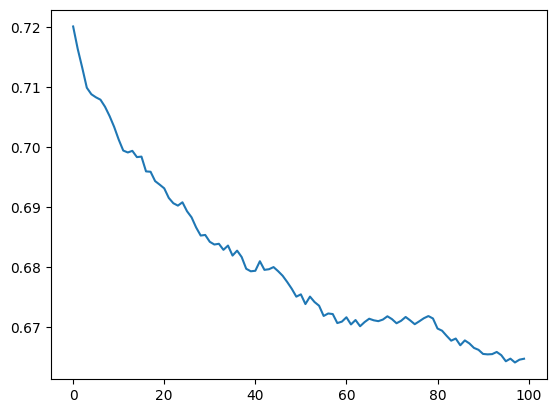

In [78]:
plt.plot(range(len(losses)),losses)

## Shapley Taylor Interactoin Index

In [79]:
import numpy as np
import torch
import torch.multiprocessing as mp

class ShapleyTaylorInteractionIndex:
    def __init__(self,
            encodings,
            predictor,
            device,
            num_permutations: int|None = None,
            ):
        """
        encodings expected dimension = (individuals,genes,gene_embedding dimension)

        """
        self.num_permutations = num_permutations
        self.encodings = encodings
        self.predictor = predictor
        self.baseline = self.caluculate_baseline(self.encodings)
        self.num_individuals = self.encodings.shape[0]
        self.num_genes = self.encodings.shape[1]

    def caluculate_baseline(self, encodings):
        #verify this is right
        baseline = torch.mean(encodings, dim =0)
        return baseline

    def generate_permutations(self, num_permutations, num_genes):
        permutations = [np.random.permutation(num_genes) for _ in range(num_permutations)]
        return permutations

    def generate_stratified_permutations(self, num_permutations, num_genes, encodings):
        pass

    def global_shapely_interaction_index(self, num_permutations,shapley_values = True):
        if not num_permutations:
            if not self.num_permutations:
                raise ValueError("num_permutations can not be none")
            else:
                num_permutations=self.num_permutations

        #intitialize matrix
        global_shapley_interactions = torch.zeros(size=(self.num_individuals,self.num_genes,self.num_genes))
        #make the permutation matrix
        permutations = self.generate_permutations(num_permutations,self.num_genes)
        """
        mp.set_start_method('spawn', force=True)  # Force if already set
        num_processes = mp.cpu_count()
        if num_processes > num_permutations:
          num_processes = num_permutations
        pool = mp.Pool(processes=num_processes)
        #iterate over individuals, could be parallelized
        results = pool.starmap(self.local_shapley_interaction_index, [(permutations,k, shapley_values) for k in range(self.num_individuals)])
        pool.close()
        pool.join()
        global_shapley_interactions = torch.stack(results, axis=0)
        """

        for k in range(self.num_individuals):
            global_shapley_interactions[k] = self.local_shapley_interaction_index(permutations,k, shapley_values)
            print(f"finished up to {k}")

        #check axis

        global_shapley_interactions = torch.mean(global_shapley_interactions,axis = 0)
        return global_shapley_interactions

    def local_shapley_interaction_index(self,permutations,k, shapley_values):
        local_shapley_interaction = torch.zeros(size=(len(permutations),self.num_genes,self.num_genes))
        if shapley_values:
            marginal_contribution = torch.zeros(size=(len(permutations),self.num_genes))
        for iter, pi in enumerate(permutations):
            s = []
            for i in pi:
                if i >=1: s.append(i-1)
                for j in pi[i+1:]:
                    local_shapley_interaction[iter] = self.interaction_score(s,i,j,k)
                if shapley_values:
                    marginal_contribution[iter] = self.marginal_contribution(s,i,k)
        local_shapley_interaction = torch.mean(local_shapley_interaction,axis=0)
        local_shapley_interaction = local_shapley_interaction + +local_shapley_interaction.T
        if shapley_values:
            local_shapley_interaction += torch.diag(torch.mean(marginal_contribution, axis =0))
        #maybe add shapley value here
        return local_shapley_interaction

    def interaction_score(self, s, i, j,k):
        s_ij = self.mask_input(s+[i,j],k).flatten()
        s_i = self.mask_input(s+[i],k).flatten()
        s_j = self.mask_input(s+[j],k).flatten()
        s = self.mask_input(s,k).flatten()
        output_s_ij = self.predictor(s_ij.to(device))
        output_s_i = self.predictor(s_i.to(device))
        output_s_j = self.predictor(s_j.to(device))
        output_s = self.predictor(s.to(device))

        return output_s_ij-output_s_i-output_s_j+output_s

    def marginal_contribution(self,s,i,k):
        s_i = self.mask_input(s+[i],k).flatten()
        s = self.mask_input(s,k).flatten()
        output_s_i = self.predictor(s_i.to(device))
        output_s = self.predictor(s.to(device))
        return output_s_i - output_s

    def mask_input(self, index_set, k):
        input = self.baseline.clone()
        input[index_set]=self.encodings[k][index_set]
        return input







In [80]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [81]:
stii = ShapleyTaylorInteractionIndex(reshaped_embeddings.permute(1,0,2), model, device=device)

In [82]:
interaction_index = stii.global_shapely_interaction_index(1)

finished up to 0
finished up to 1
finished up to 2
finished up to 3
finished up to 4
finished up to 5
finished up to 6
finished up to 7
finished up to 8
finished up to 9
finished up to 10
finished up to 11


In [83]:
interaction_index[interaction_index != 0]

tensor([], grad_fn=<IndexBackward0>)